In [1]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

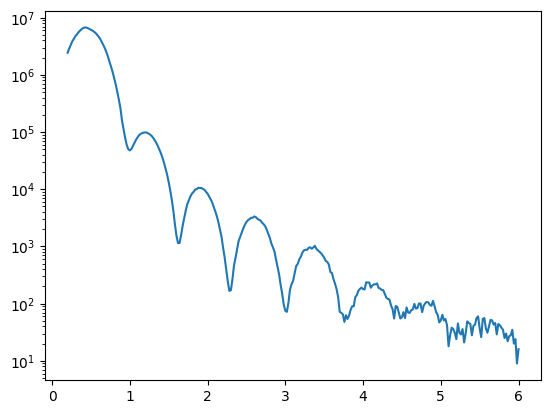

In [2]:
import matplotlib.pyplot as plt

from reflecto.io_utils import load_xrr_dat
from reflecto.physics_utils import tth2q
from reflecto.simulate.simul_genx import ParamSet, param2refl

data_file = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data2\#1.dat")
weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\power0_95_tune")

tths, R_raw = load_xrr_dat(data_file)
q_raw = tth2q(tths)
plt.plot(tths, R_raw)
plt.yscale("log")

[Inference] Device: cuda
[Inference] Grid Generation: Power=0.95, Points=1000
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\power0_95_tune\best.pt
>>> NN Prediction:
Thickness : 100.90 Å
Roughness : 5.29 Å
SLD : 21.437 (10⁻⁶ Å⁻²)


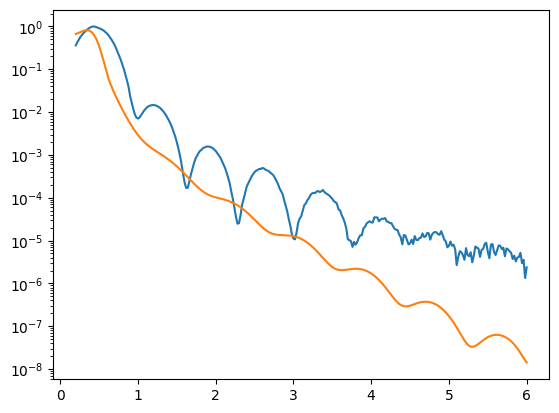

In [3]:
from fitting_engine import GenXFitter
from inference import XRRInferenceEngine

inference_engine = XRRInferenceEngine(exp_dir=weights_path)

pred_d, pred_sig, pred_sld = inference_engine.predict(q_raw, R_raw)


print(">>> NN Prediction:")
print(f"Thickness : {pred_d:.2f} Å")
print(f"Roughness : {pred_sig:.2f} Å")
print(f"SLD : {pred_sld:.3f} (10⁻⁶ Å⁻²)")

param = ParamSet(pred_d, pred_sig, pred_sld)
sim_refl = param2refl(q_raw, [param])

plt.plot(tths, R_raw / R_raw.max())
plt.plot(tths, sim_refl)
plt.yscale("log")

In [4]:
nn_initial_params = ParamSet(pred_d, pred_sig, pred_sld)

fitter = GenXFitter(q_raw, R_raw, nn_initial_params)

# 피팅 실행
final_results = fitter.run(verbose=True)
    # ---------------------------------------------------------

print("\n" + "-"*40)
print("FINAL ANALYSIS RESULT")
print("-"*40)
for param_name, value in final_results.items():
    print(f"{param_name:15s}: {value:.4f}")
print("="*40)


fitter.plot()

# 결과 반환
result = {
"nn_preds": (pred_d, pred_sig, pred_sld),
"final_params": final_results,
"fitter": fitter,
}

for key, val in result.items():
    print(f"{key}: {val}")


[GenX] Step 1: Fitting I0 (Linear)...


KeyboardInterrupt: 

In [ ]:
from inference_pipeline import run_xrr_analysis

data_root = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data")
weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\sio2_random2")
inference_engine = XRRInferenceEngine(exp_dir=weights_path)

for dat_file in data_root.glob("*.dat"):
    print(dat_file.name)
    run_xrr_analysis(dat_file, weights_path, inference_engine, verbose=False, show_plot=True)

[Inference] Device: cuda


FileNotFoundError: Statistics file not found: D:\03_Resources\Data\XRR_AI\data\one_layer\sio2_random2\stats.pt